## Grand Canyon elevation classification using the NASADEM dataset

In this tutorial, will be demonstrated how to classify the terrain elevation of the Grand Canyon, an area of interest around the Grand Canyon National Park. The data that will be used is hosted on the [Microsoft Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog) and it's called [NASADEM](https://github.com/microsoft/AIforEarthDatasets#nasadem).

[NASADEM](https://github.com/microsoft/AIforEarthDatasets#nasadem) dataset provides global topographic data at 1 arc-second (~30m) horizontal resolution, derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM). The data are stored in the Azure Storage in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

The tutorial will walk you through:
- Load and render the area of interest image using the Grand Canyon coordinates.
- Classify the data using the [natural breaks classification](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.natural_breaks.html) function from [xarray-spatial](https://xarray-spatial.org/) Python library.
- Shade the classified data using the [shade](https://datashader.org/api.html#datashader.transfer_functions.shade) function provided by [datashader](https://datashader.org/).

### Loading the area of interest image

To load the image according to the coordinates will be used a helpful function used on [Accessing NASADEM data on Azure (NetCDF)](https://github.com/microsoft/AIforEarthDataSets/blob/main/data/nasadem-nc.ipynb) to build the full URL.

In [1]:
import requests

nasadem_blob_root = "https://nasademeuwest.blob.core.windows.net/nasadem-cog/v001/"
nasadem_file_index_url = nasadem_blob_root + "index/nasadem_cog_list.txt"
nasadem_content_extension = ".tif"
nasadem_file_prefix = "NASADEM_HGT_"
nasadem_file_list = None

nasadem_file_list = requests.get(nasadem_file_index_url).text.split("\n")

In [2]:
import math


def get_nasadem_filename(coord):
    """
    Get the NASADEM filename for a specified latitude and longitude.
    """
    lat = coord[0]
    lon = coord[1]

    ns_token = "n" if lat >= 0 else "s"
    ew_token = "e" if lon >= 0 else "w"

    lat_index = abs(math.floor(lat))
    lon_index = abs(math.floor(lon))

    lat_string = ns_token + "{:02d}".format(lat_index)
    lon_string = ew_token + "{:03d}".format(lon_index)

    filename = nasadem_file_prefix + lat_string + lon_string + nasadem_content_extension

    if filename not in nasadem_file_list:
        print("Lat/lon {},{} not available".format(lat, lon))
        filename = None

    return filename

In [3]:
grand_canyon_coord = [36.101690, -112.107676]

url = nasadem_blob_root + get_nasadem_filename(grand_canyon_coord)

As we have the image URL, we can use the xarrray [open_rasterio](http://xarray.pydata.org/en/stable/generated/xarray.open_rasterio.html) function to load the data and drop the band dimension using the mapshader [squeeze](https://mapshader.org/reference/_autosummary/mapshader.transforms.squeeze.html) function.

In [4]:
from mapshader.transforms import squeeze
import xarray as xr

img_arr = xr.open_rasterio(url)
img_arr = squeeze(img_arr, "band")

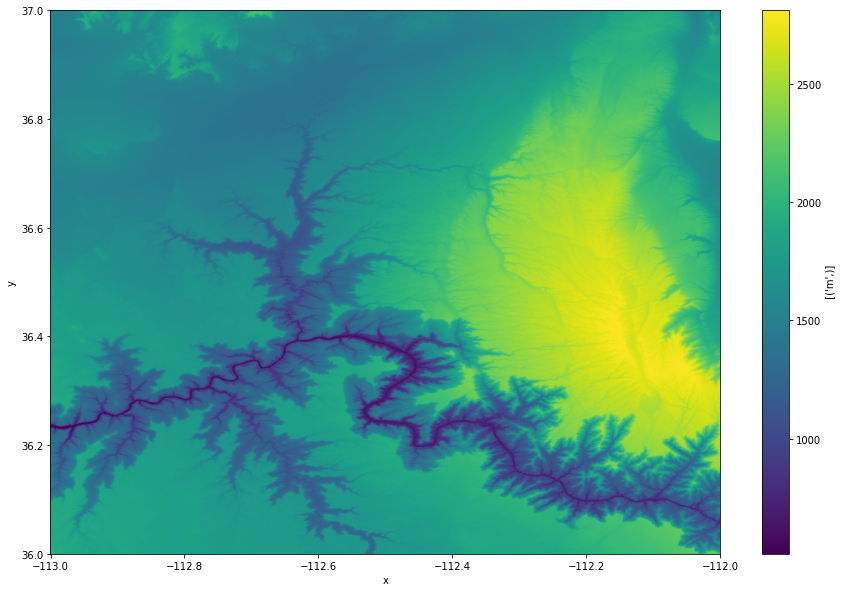

In [5]:
img_arr.plot.imshow(figsize=(15, 10))

### Classifying the elevation

The natural breaks function classifies the data using the [Jenks Natural Breaks Classification](http://wiki.gis.com/wiki/index.php/Jenks_Natural_Breaks_Classification) method, which is designed to optimize the arrangement of a set of values into natural classes, which is found naturally in a data set.

In [6]:
from xrspatial.classify import natural_breaks

natural_breaks_agg = natural_breaks(img_arr, num_sample=20000, k=15)

### Shading the classified data

When shading the classified data, will be used the xarray-spatial [hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html?highlight=hillshade) function to create a raster illumination based on the altitude to highlight the Grand Canyon elevations.

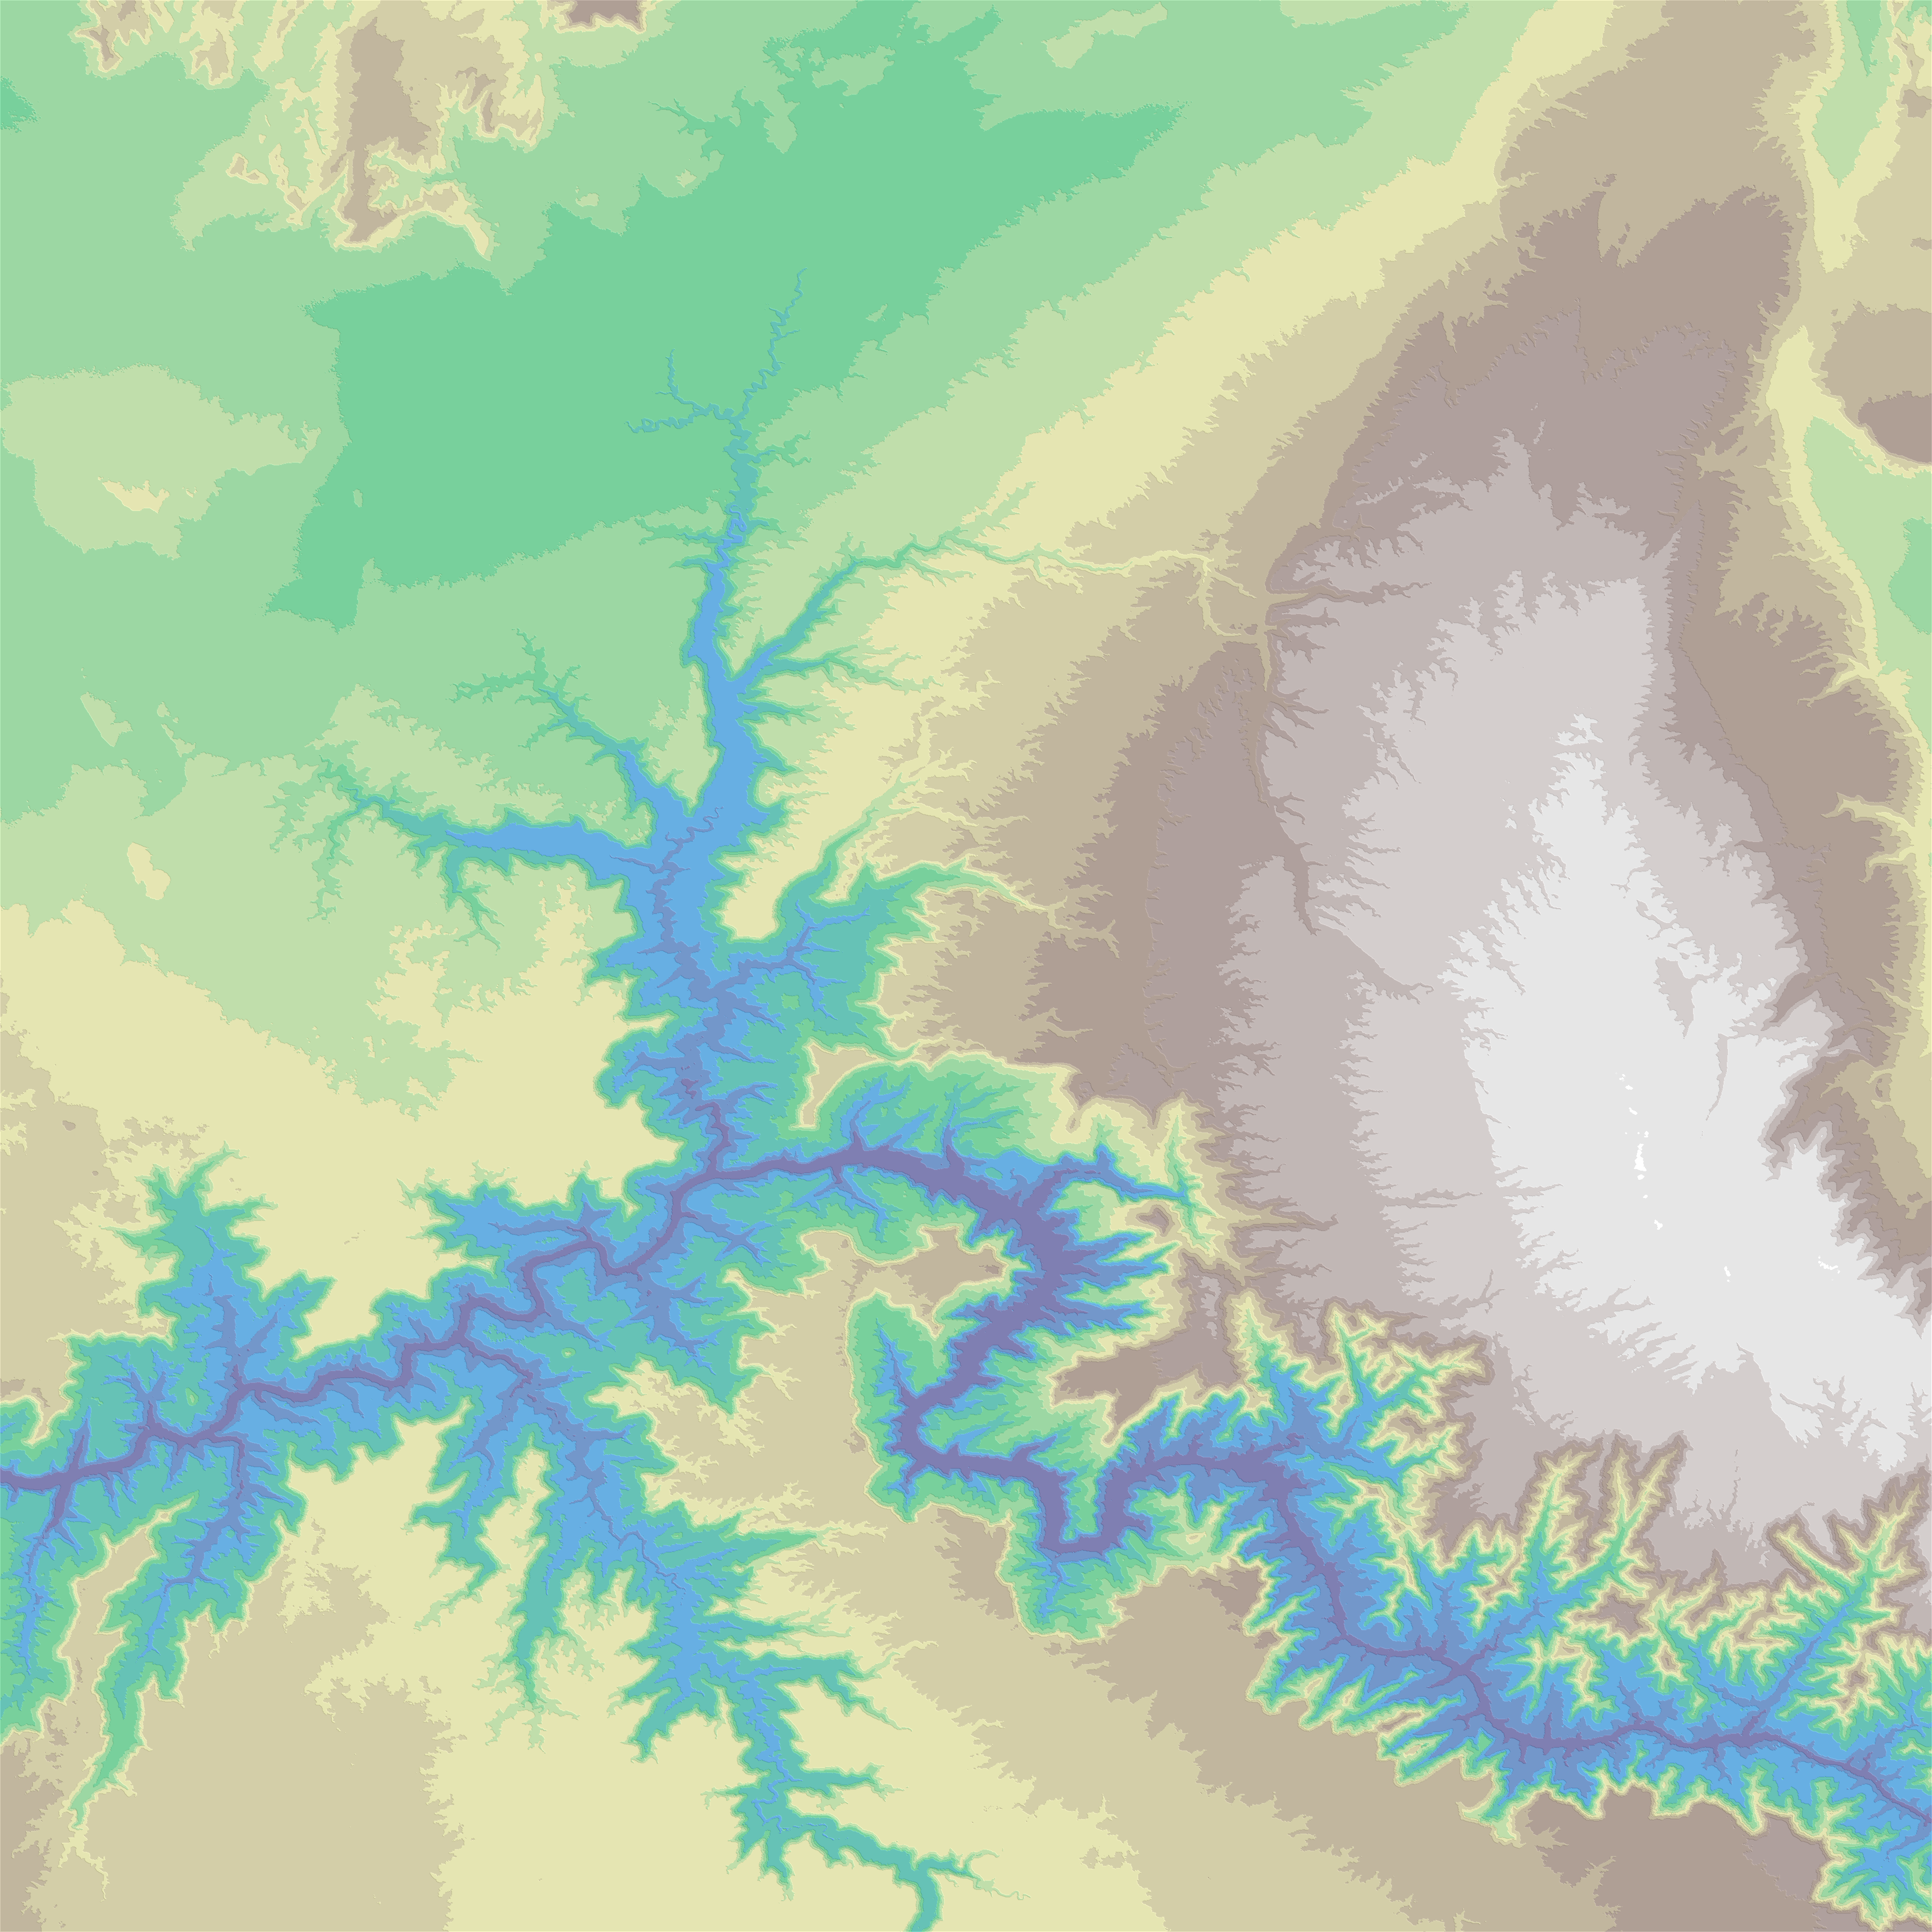

In [7]:
from datashader.transfer_functions import shade, stack
import matplotlib.pyplot as plt
from xrspatial import hillshade

stack(
    shade(
        hillshade(natural_breaks_agg), cmap=["gray", "white"], alpha=255, how="linear"
    ),
    shade(natural_breaks_agg, cmap=plt.get_cmap("terrain"), alpha=128, how="linear"),
)

As we can see in the above image, the Grand Canyon elevation could be easily identified according to the classified data based on the colors. For instance, the wild blue yonder color area has the smallest elevation with ≈700m of altitude, the tan brown color area has ≈1700m of elevation, and the highest elevation on the blue-grey color area with ≈2500m of altitude.